In [1]:
import pandas as pd
import numpy as np
import pickle
import math
from matplotlib import pyplot as plt
%matplotlib inline

## Load SIRENE and filter

In [10]:
data_sirene = pd.read_csv('data_sirene.csv')

In [11]:
data_sirene_metro = data_sirene
data_sirene_metro = data_sirene_metro[data_sirene_metro.X>0]
data_sirene_metro = data_sirene_metro[data_sirene_metro.X<1400000]

(array([   2.,    6.,    4.,    3.,    4.,    3.,    2.,    3.,    9.,
           5.,    2.,    5.,    9.,    6.,    3.,    3.,    7.,    6.,
          12.,   15.,   35.,   24.,   23.,   14.,   18.,   26.,   31.,
          32.,   15.,   17.,   21.,   11.,   32.,   18.,   11.,   26.,
          13.,   11.,   16.,   43.,   39.,   14.,   22.,   20.,   33.,
          32.,  157.,  234.,   73.,   28.,   32.,   35.,   47.,   26.,
          19.,   13.,    9.,   19.,   37.,   17.,   21.,   23.,   18.,
          27.,   70.,   44.,   24.,   23.,   24.,   33.,   26.,   23.,
          47.,   33.,   24.,   19.,    5.,   15.,    7.,   17.,   19.,
          26.,   34.,   17.,    1.,    1.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    4.,    3.,    1.,    0.,    1.,    6.]),
 array([  129440.6356852 ,   140502.49582041,   151564.35595561,
          162626.21609082,   173688.07622602,   184749.93636123,
          195811.79649643,   206873.65663164,   217935.51676684,
          22899

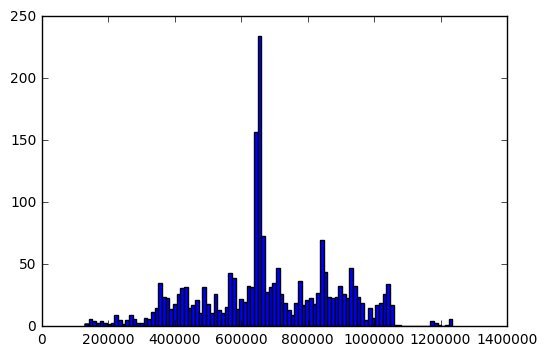

In [12]:
plt.hist(data_sirene_metro.X[::1000], bins=100)

In [13]:
data_sirene_metro = data_sirene_metro[data_sirene_metro.effectif > 150]

In [14]:
len(data_sirene_metro)

12456

In [15]:
data_sirene_metro = data_sirene_metro[data_sirene_metro.NJ.map(lambda nj: str(nj)[0]!='7')] # remove public sector

In [16]:
len(data_sirene_metro)

9042

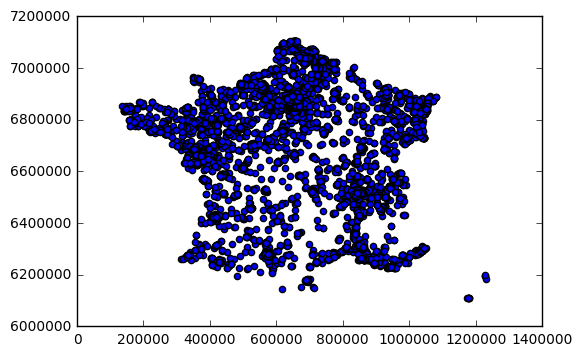

In [17]:
plt.scatter(data_sirene_metro.X, data_sirene_metro.Y)

In [18]:
Xmin = 0
Xmax = 1400000
Ymin = 6000000
Ymax = 7200000
tile_size = 25000

In [19]:
nb_tiles_sirene_x = int((Xmax-Xmin)/tile_size)
nb_tiles_sirene_y = int((Ymax-Ymin)/tile_size)
amplitudeX = Xmax-Xmin
amplitudeY = Ymax-Ymin

In [24]:
tiles_sirene = {}
for ix in range(nb_tiles_sirene_x):
    for iy in range(nb_tiles_sirene_y):
        tiles_sirene[(ix, iy)] = []

In [25]:
def X2ix(X):
    return int(math.floor((X-Xmin)/tile_size))
def Y2iy(Y):
    return int(math.floor((Y-Ymin)/tile_size))

In [26]:
for i, row in data_sirene_metro.iterrows():
    X, Y, effectif, nj = row
    ix = X2ix(X)
    iy = Y2iy(Y)
    tiles_sirene[(ix, iy)].append((X, Y, effectif))

## Compute at one point

In [27]:
def distance(X1, Y1, X2, Y2):
    return math.sqrt(math.pow((X1-X2)/1000, 2.) + math.pow((Y1-Y2)/1000, 2.))

In [28]:
def compute_point(X, Y):
    ix = X2ix(X)
    iy = Y2iy(Y)
    indexes = [(ix-1, iy-1), (ix, iy-1), (ix+1, iy-1),
              (ix-1, iy), (ix, iy), (ix+1, iy),
              (ix-1, iy+1), (ix, iy+1), (ix+1, iy+1)]
    indexes = [(ix, iy) for ix, iy in indexes if ix>=0 and iy>=0 and ix<nb_tiles_sirene_x and iy<nb_tiles_sirene_y]
    local_list_list = [element for i in indexes for element in tiles_sirene[i]]
    
    value = 0.
    for X_sirene, Y_sirene, effectif in local_list_list:
        if distance(X_sirene, Y_sirene, X, Y) < 25:
            value += 1.
            
    return value

In [29]:
def ix2X(ix, size_pixel):
    return ix*size_pixel + Xmin
def iy2Y(iy, size_pixel):
    return iy*size_pixel + Ymin

In [30]:
size_pixel = 1000
n_pixel_X = int(amplitudeX/size_pixel + 1)
n_pixel_Y = int(amplitudeY/size_pixel + 1)

In [31]:
image = np.zeros((n_pixel_Y, n_pixel_X))
for ix in range(n_pixel_X):
    for iy in range(n_pixel_Y):
        X = ix2X(ix, size_pixel)
        Y = iy2Y(iy, size_pixel)
        image[iy, ix] = compute_point(X, Y)

In [32]:
threshold = 3.5

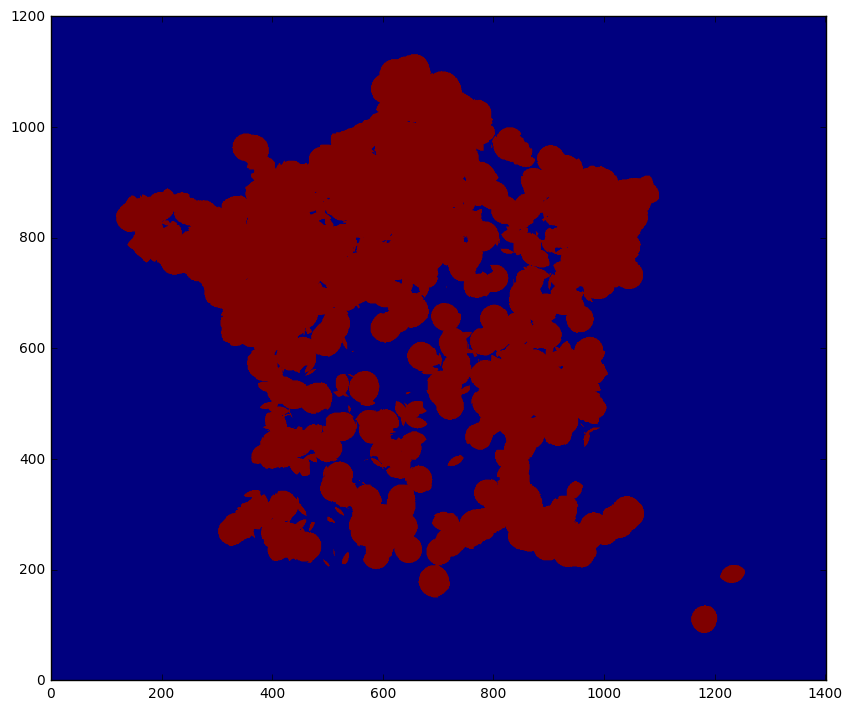

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(image>threshold)
plt.gca().invert_yaxis()
plt.savefig('map3entreprises.png')

## Compute population

In [34]:
commune_data = pickle.load(open('commune_data.csv', 'rb'))

In [35]:
red = 0.
blue = 0.
for code_insee, d in commune_data.items():
    if compute_point(d['X'], d['Y']) <= threshold:
        blue += d['active_population']
    else:
        red += d['active_population']

In [36]:
red+blue, red, blue, blue/(red+blue)

(30503994.0, 28445764.0, 2058230.0, 0.06747411502900243)